# Text Mining

# Lecture 3: Vector Space Retrieval 

![img](https://3.bp.blogspot.com/_tOOi3R89e74/TUeyueig7ZI/AAAAAAAAAJQ/QHL-VLEWook/s1600/vector_space.png)

## Group Assignment

### General Goal

- Proposal (~15 pages) for an innovative, useful application that uses text mining.

- This can be: website, app, service, but also an experiment.

### Set-up

- Send an email to c.d.emmery@uvt.nl before this Thursday 23:59 to register as either a group (5 persons) or single student.
- If you're a group: please list your names.
- If you're a student: you will be matched.
- You can collaborate with the other timeslot.
- The group will be graded as one.
- Deadline: 26th of October, 23:59h.

### Outline

- Abstract
- Introduction: explain the need for this application or experiment (your proposal should be original).
- Description of technical approach (methodology):
    - Which techniques (general names, not specific libraries) will you use, and why? 
    - Use at least three different techniques **that work well together**.
    - What kind of data will you use? How will you obtain those? What information will you use?
    - Explain and motivate the pipeline (e.g. cleaning, parsing, weighting).
- Discussion (including limitations and expected problems) and conclusion.

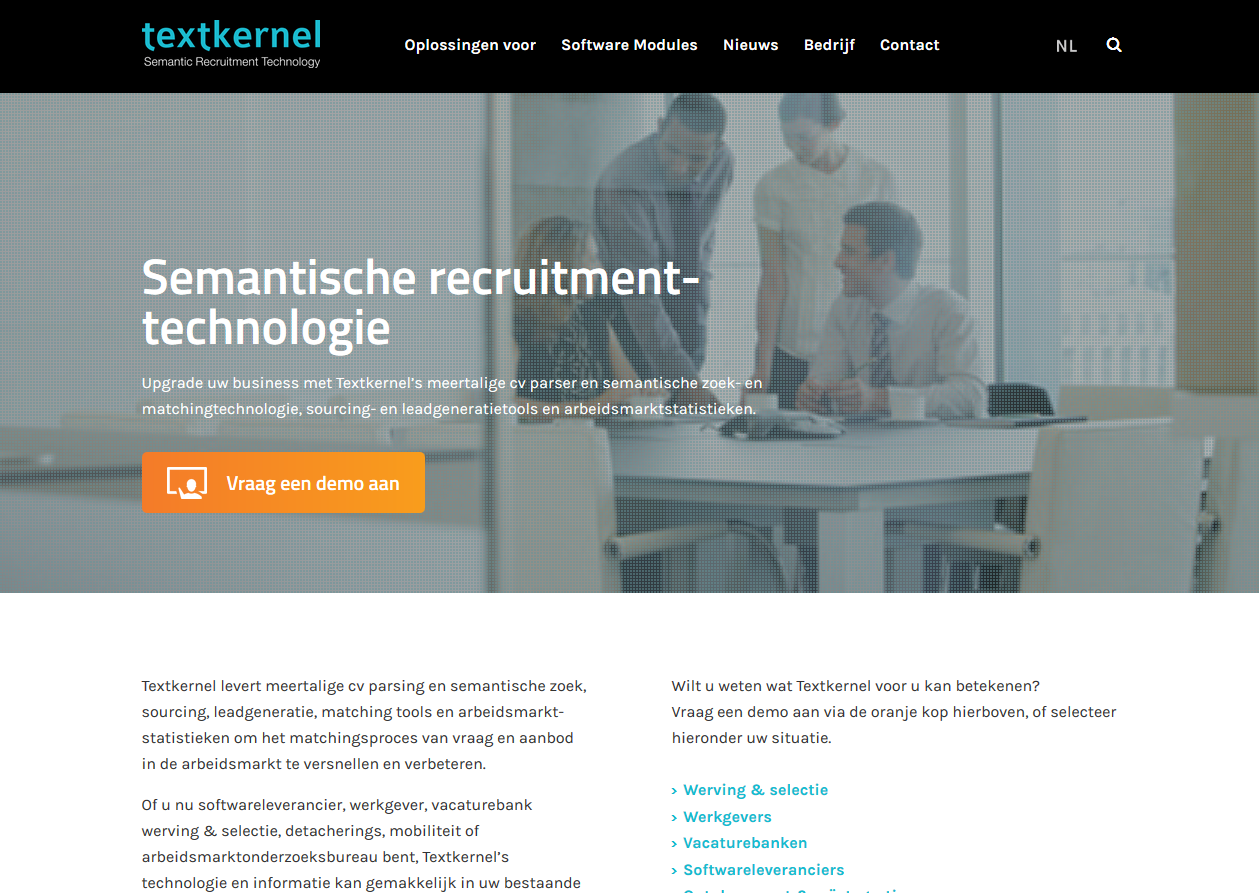

In [1]:
from IPython.display import Image
Image(filename='kernel.png')

## Word Vectors

### Recap

Data Collection -> Information Selection -> Pre-processing -> ??? -> Classification

Plain Text -> Tokens -> Vocabulary -> 'Word' Vectors

Word - Token - Term

### Document to Vector

In [2]:
document = "this is a text this is"
tokens = document.split()
tokens

['this', 'is', 'a', 'text', 'this', 'is']

In [3]:
vocabulary = set(tokens)
vocabulary

{'a', 'is', 'text', 'this'}

In [4]:
# warning, this example is simple but actually runs pretty slow
# on real data
document_vector = [tokens.count(term) for term in sorted(vocabulary)]
document_vector

[1, 2, 1, 2]

### Documents to Vectors

In [5]:
documents = ["this is a text this is", "and here is another text"]
doc_tokens = [document.split() for document in documents]
vocabulary = set([term for tokens in doc_tokens for term in tokens])
vocabulary

{'a', 'and', 'another', 'here', 'is', 'text', 'this'}

In [6]:
import numpy as np

document_vectors = [[tokens.count(term) for term in sorted(vocabulary)]
                    for tokens in doc_tokens]
np.matrix(document_vectors)

matrix([[1, 0, 0, 0, 2, 1, 2],
        [0, 1, 1, 1, 1, 1, 0]])

### Easier

In [7]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer()
cv

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [8]:
document_vectors = cv.fit_transform(documents)
document_vectors.todense()

matrix([[0, 0, 0, 2, 1, 2],
        [1, 1, 1, 1, 1, 0]], dtype=int64)

In [9]:
cv.vocabulary_

{'and': 0, 'another': 1, 'here': 2, 'is': 3, 'text': 4, 'this': 5}

## Vector Retrieval

### Boolean Vectors

In [10]:
A = "text about stuff"
B = "stuff about text"
C = "text about vectors"
D = "vectors are handy"

Which document is D most similar to?

| doc  | about | are | handy | stuff | text | vectors |
| ---- | ----- | --- | ----- | ----- | ---- | ------- |
| A    | 1     |     |       | 1     | 1    |         |
| B    | 1     |     |       | 1     | 1    |         |
| C    | 1     |     |       |       | 1    | 1       |
| D    |       | 1   | 1     |       |      | 1       |

- `Document * Term` or `Term * Document` Matrix
- Bag of Words (BoW)

### Jaccard Coefficient - $J(A, B) = \frac{| A \cap B |}{| A \cup B |}$

| doc  | about | are | handy | stuff | text | vectors |
| ---- | ----- | --- | ----- | ----- | ---- | ------- |
| A    | 1     |     |       | 1     | 1    |         |
| B    | 1     |     |       | 1     | 1    |         |
| C    | 1     |     |       |       | 1    | 1       |
| D    |       | 1   | 1     |       |      | 1       |

In [11]:
As = set(A.split())
Bs = set(B.split())
Cs = set(C.split())
Ds = set(D.split())

print("As Ds:", len(As & Ds) / len(As | Ds))
print("As Bs:", len(As & Bs) / len(As | Bs))
print("Cs Ds:", len(Cs & Ds) / len(Cs | Ds))

As Ds: 0.0
As Bs: 1.0
Cs Ds: 0.2


- Order
- Context
- Information?

### Term Frequencies - $tf_{t,d}$

t = term, d = document

In [12]:
from glob import glob

cv = CountVectorizer()
doc_names, documents = zip(*[(doc, open(doc).read()) for doc in glob('../Week 1 - Introduction/data/*.txt')])
D = cv.fit_transform(documents)
D

<6x5361 sparse matrix of type '<class 'numpy.int64'>'
	with 9245 stored elements in Compressed Sparse Row format>

In [13]:
print([x.replace('../Week 1 - Introduction/data/', '') for x in doc_names])

['computer-vision.txt', 'artificial-intelligence.txt', 'machine-learning.txt', 'information-retrieval.txt', 'text-mining.txt', 'natural-language-processing.txt']


In [14]:
cv.vocabulary_['learning']

2970

In [15]:
D[:,2970].todense()

matrix([[ 10],
        [ 46],
        [134],
        [  2],
        [  6],
        [ 27]])

### Issues

- Frequency 10 is more important than 100, but also * 10?

In [16]:
np.log10(D.todense() + 1)[:,2970]

matrix([[ 1.04139269],
        [ 1.67209786],
        [ 2.13033377],
        [ 0.47712125],
        [ 0.84509804],
        [ 1.44715803]])

- Longer documents shouldn't be more likely to be interesting.
- Rare terms should be informative (amongst all documents).
    - If D1 and D2 both have 'cross-validation' in their vectors, and all the other documents don't, that should be a very strong similarity indication.

Latter: document frequency.

### Document Frequency - $idf_t = \log_{10} \frac{N}{df_{t}}$

Number of documents that contain some term. Inverse measure of informativeness.

* N = number of documents
* $df_t$ = document frequency of term $t$

In [17]:
def idf(term):
    return np.log10(len(documents) / sum([term in d.split() for d in documents]))

print(idf("learning"))
print(idf("parsing"))
print(idf("naive"))

0.0
0.47712125472
0.778151250384


### TF\*IDF Weighting

Also tf-idf, tf.idf, etc.

$w_{t,d} = (1 + \log tf_{t,d} ) \cdot \log_{10} \frac{N}{df_{t}}$

Increases with rarity and occurences.

In [18]:
document_tokens = documents[4].split()
(np.log(document_tokens.count("text") + 1)) * idf("text")

0.31730563493470437

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer()

D = tfidf.fit_transform(documents)
D.todense()[:,2970]

matrix([[ 0.02036652],
        [ 0.05364644],
        [ 0.36599158],
        [ 0.00425381],
        [ 0.01783667],
        [ 0.06741781]])

### TF\*IDF Weighting II

In [20]:
print([x.replace('../Week 1 - Introduction/data/', '') for x in doc_names])

['computer-vision.txt', 'artificial-intelligence.txt', 'machine-learning.txt', 'information-retrieval.txt', 'text-mining.txt', 'natural-language-processing.txt']


In [21]:
tfidf.vocabulary_['text']

4882

In [22]:
D.todense()[:,4882]

matrix([[ 0.00705181],
        [ 0.001346  ],
        [ 0.        ],
        [ 0.03436678],
        [ 0.3431035 ],
        [ 0.063401  ]])

So how do we know if they are similar?

## Vector Space Retrieval

### Vectors in Space

- Features
- Points

Below: sentence = document, term = word

* term 1 = "a"
* term 2 = "sentence"
* term n = "that"


* sentence 1 = "a that"
* sentence 2 = "that sentence"
* sentence n = "a sentence"

![img](https://3.bp.blogspot.com/_tOOi3R89e74/TUeyueig7ZI/AAAAAAAAAJQ/QHL-VLEWook/s1600/vector_space.png)

### Common Display ... Mining

- 2-D
- Vector endpoints
- Vectors have a label

![img2](http://nlp.stanford.edu/IR-book/html/htmledition/img1087.png)

### Common Display Information Retrieval

- 2D
- Full vectors
- q = query

![img3](https://d2qphtmbcjv60w.cloudfront.net/content/jaminfo/9/6/637/F4.large.jpg)

### Similarity in Vector Space Models

- First need to normalize all vectors (L2 norm or Eucledian norm, results in a unit vector).

### $|| \vec{x} ||_{2} = \sqrt{\sum_i x_{i}^{2}}$
= dividing all vector points by its length (sum)

![img4](https://simonpaarlberg.com/posts/2012-06-28-latent-semantic-analyses/vector_example.png)

### $L_2$ Normalization

So:

In [23]:
import numpy as np

v1 = [-1, 3, 5]
v2 = [2, -3, 20]

v1_2 = [x / np.sqrt(sum(v1)**2) for x in v1]
v2_2 = [x / np.sqrt(sum(v2)**2) for x in v2]

print(v1_2)
print(v2_2)
print(sum(v1_2), sum(v2_2))

[-0.14285714285714285, 0.42857142857142855, 0.7142857142857143]
[0.10526315789473684, -0.15789473684210525, 1.0526315789473684]
1.0 1.0


### Similarity in Vector Space Models II

Then we can calculate cosine similarity. Inverse of angle; vectors that are 90 deg. apart have a similarity of 0, whilst perfect aligned ones have 1. Given $L_2$, simple dot product:

$a \bullet b = \sum^{n}_{i=1} a_i b_i = a_1 b_1 + a_2 b_2 + \ldots + a_n b_n$

So:

$[0.2, 0.1, 0.7] \bullet [0.4, 0.2, 0.4] = 0.2 \cdot 0.4 + 0.1 \cdot 0.2 + 0.7 \cdot 0.4  = 0.38$

### So now you know a basic $k$-NN implementation!

- The classifier $k$-NN (nearest neighbours) looks at $k$ nearest (with for example cosine distance) vectors.
- Fit/train phase: convert all documents to vectors, remember vocab for new transformation.
- Test phase: convert given document to same length vector, calculate distance to all known vectors, select top $k$.
- If you have labels: look up labels for top $k$, do (for example) majority vote, return label.